In [18]:
!pip install numpy pandas astropy torch torchvision matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from glob import glob
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d



class AGN_Dataset(Dataset):
    def __init__(self, bl_path, qso_path, dual_path, seyfert_path, max_len=2000):
        self.samples = []
        self.labels = []
        self.max_len = max_len

        # BL Lac (label 0)
        for file in glob(os.path.join(bl_path, "*.txt")):
            self.samples.append((file, "txt"))
            self.labels.append(0)

        # QSO (label 1)
        for file in glob(os.path.join(qso_path, "*.fits")):
            self.samples.append((file, "fits"))
            self.labels.append(1)

        # Dual AGN (label 2)
        for file in glob(os.path.join(dual_path, "*.fits")):
            self.samples.append((file, "fits"))
            self.labels.append(2)

        # Seyfert 1 (label 3)
        for file in glob(os.path.join(seyfert_path, "*.fits")):
            self.samples.append((file, "fits"))
            self.labels.append(3)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, file_type = self.samples[idx]
        label = self.labels[idx]

        try:
            if file_type == "txt":
                df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
                df = df.dropna().apply(pd.to_numeric, errors='coerce').dropna()
                flux = df.iloc[:, 1].values
            else:
                with fits.open(file_path) as hdul:
                    flux = np.array(hdul[1].data["flux"], dtype=np.float32)
        except Exception as e:
            print(f"Error reading file: {file_path} | {e}")
            flux = np.zeros(self.max_len)

        flux = (flux - np.mean(flux)) / (np.std(flux) + 1e-6)
        #flux = gaussian_filter1d(flux, sigma=2)


        if len(flux) > self.max_len:
            flux = flux[:self.max_len]
        else:
            flux = np.pad(flux, (0, self.max_len - len(flux)), 'constant')

        return torch.tensor(flux, dtype=torch.float32).unsqueeze(0), torch.tensor(label)



In [ ]:
import torch.nn as nn

class SpectrumCNN(nn.Module):
    def __init__(self):
        super(SpectrumCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)
        self.conv2 = nn.Conv1d(16, 32, 5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 256, 64)
        self.fc2 = nn.Linear(64, 4)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x.view(x.size(0), -1))
        x = torch.relu(self.fc1(x))
        return self.fc2(x)



C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


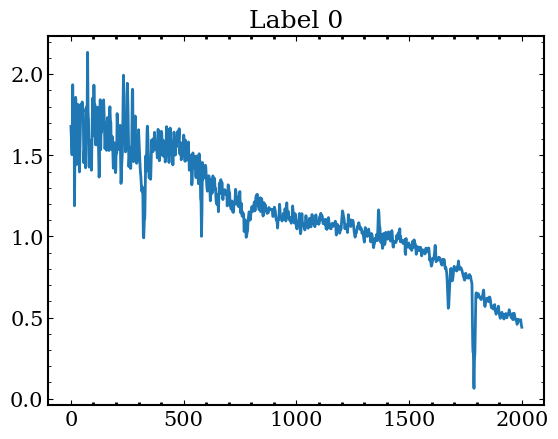

C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


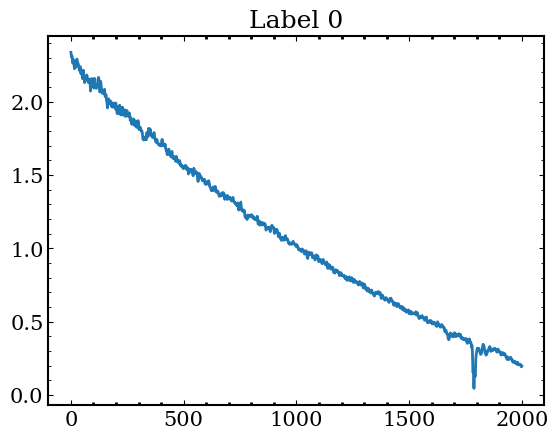

C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


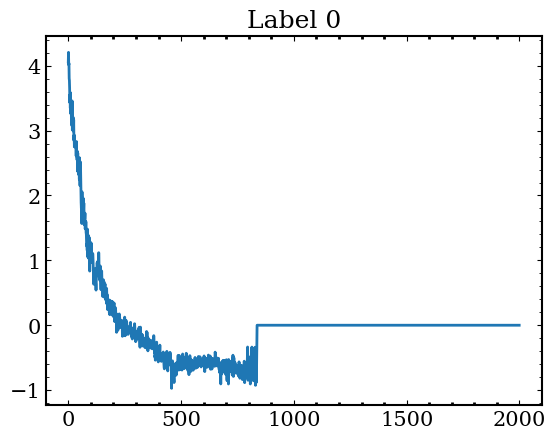

C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


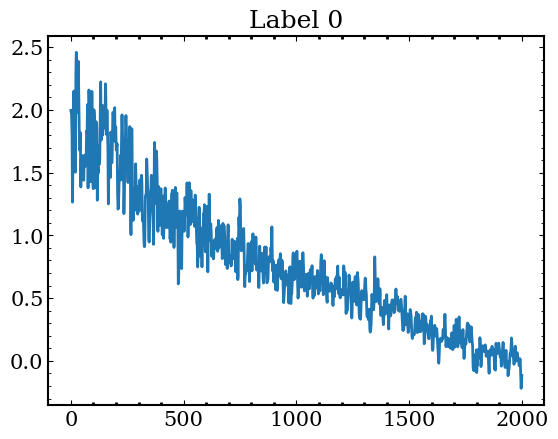

C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


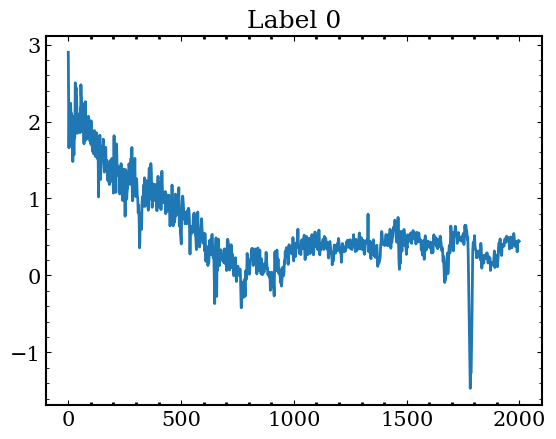

Input shape: torch.Size([16, 1, 2000])
Labels: tensor([0, 1, 3, 1, 3, 3, 0, 3, 0, 3, 2, 0, 3, 1, 0, 0])


C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is d

In [ ]:
import matplotlib.pyplot as plt


# Paths
bl_path = r"C:\Users\jimmy\OneDrive\Astron100\BLL"
qso_path = r"C:\Users\jimmy\OneDrive\Astron100\qso_spectra"
dual_path = r"C:\Users\jimmy\OneDrive\Astron100\sdss_spectra_dual"
seyfert_path = r"C:\Users\jimmy\OneDrive\Astron100\sdss_spectra_seyfert"

dataset = AGN_Dataset(bl_path, qso_path, dual_path, seyfert_path)

for i in range(5):
    flux, label = dataset[i]
    plt.plot(flux.squeeze())
    plt.title(f"Label {label}")
    plt.show()


dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check one batch
for inputs, labels in dataloader:
    print("Input shape:", inputs.shape)  
    print("Labels:", labels)             
    break


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrumCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt


train_losses = []
train_accuracies = []

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0


    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)


    acc = correct / len(dataset)
    train_losses.append(total_loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_losses, label="Training Loss")
ax1.set_title("Training Loss vs Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(train_accuracies, label="Training Accuracy")
ax2.set_title("Training Accuracy vs Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.style.use('default')

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams["axes.linewidth"] = 1.5

plt.show()



C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\1430663622.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is d

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x16000 and 8192x64)

In [ ]:

import matplotlib.pyplot as plt

def predict_single(file_path, file_type, model, max_len=1024):
    if file_type == "txt":
        df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=["Wavelength", "Flux"])
        flux = df["Flux"].values
    else:
        with fits.open(file_path) as hdul:
            flux = np.array(hdul[1].data["flux"])

    flux = (flux - np.mean(flux)) / (np.std(flux) + 1e-6)
    

        # --- ADD THIS TO CHECK ---
    plt.plot(flux)
    plt.title(f"Raw flux from {file_path.split('/')[-1]}")
    plt.xlabel("Pixel index")
    plt.ylabel("Flux")
    plt.show()
    # -------------------------
    
    if len(flux) > max_len:
        flux = flux[:max_len]
    else:
        flux = np.pad(flux, (0, max_len - len(flux)), 'constant')

    flux_tensor = torch.tensor(flux, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(flux_tensor)
        predicted_class = torch.argmax(pred).item()

    class_map = {
        0: "BL Lac",
        1: "QSO",
        2: "Dual AGN",
        3: "Seyfert 1"
    }

    return class_map[predicted_class]


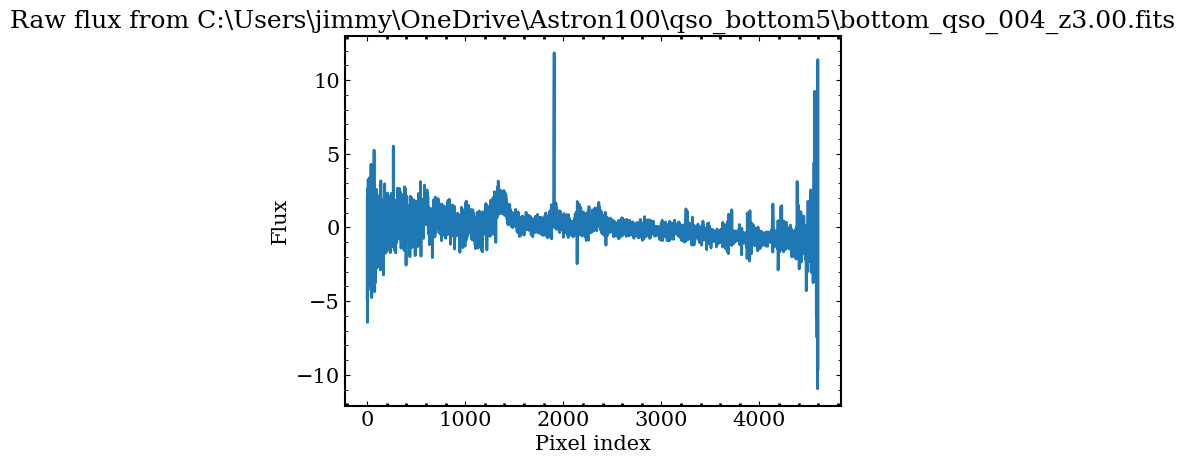

QSO


C:\Users\jimmy\AppData\Local\Temp\ipykernel_37348\2325968769.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=["Wavelength", "Flux"])


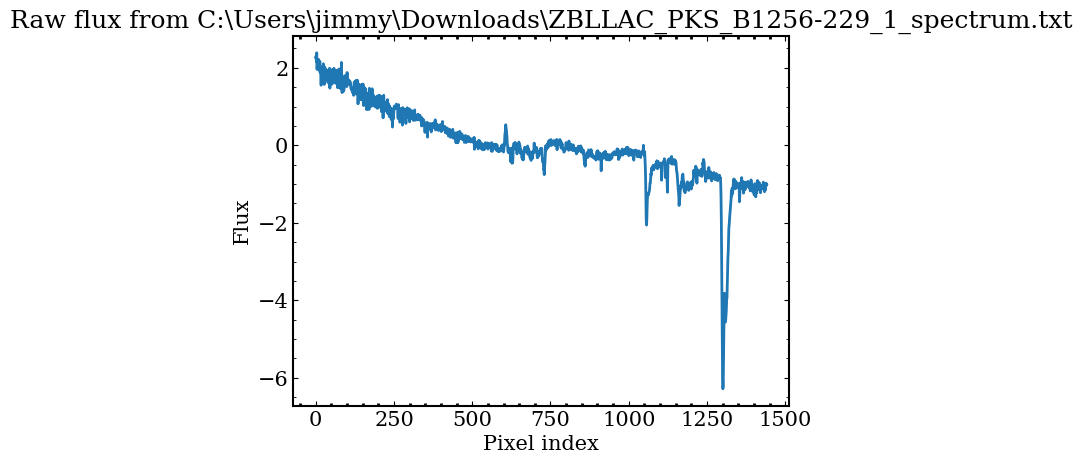

BL Lac


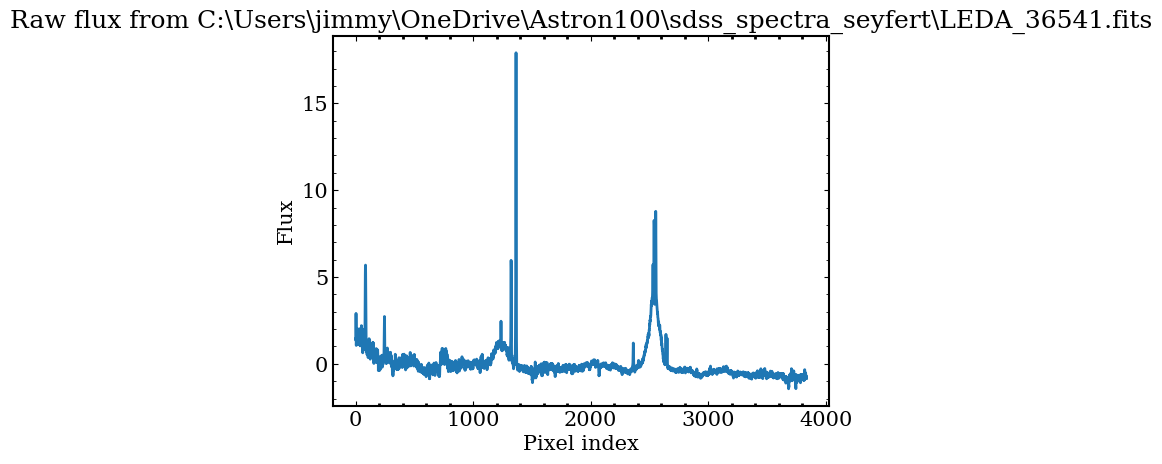

Seyfert 1


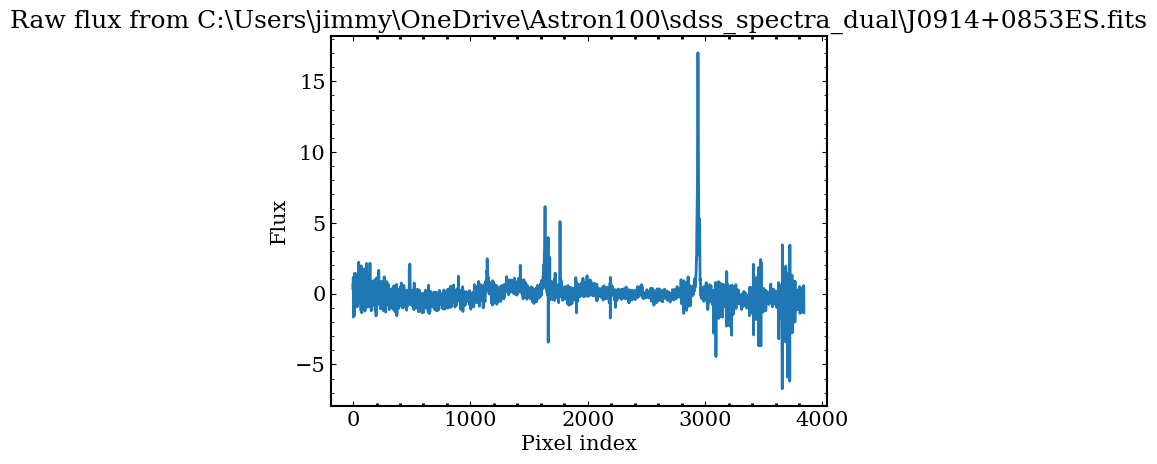

Dual AGN


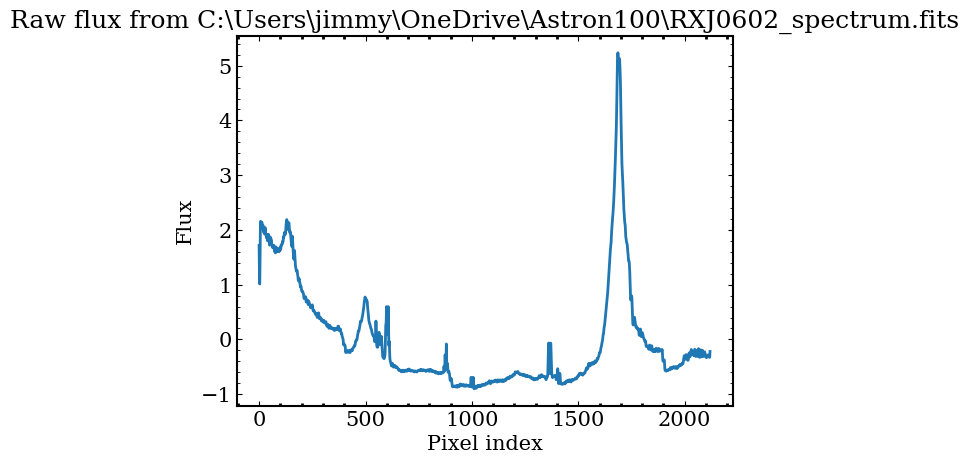

BL Lac


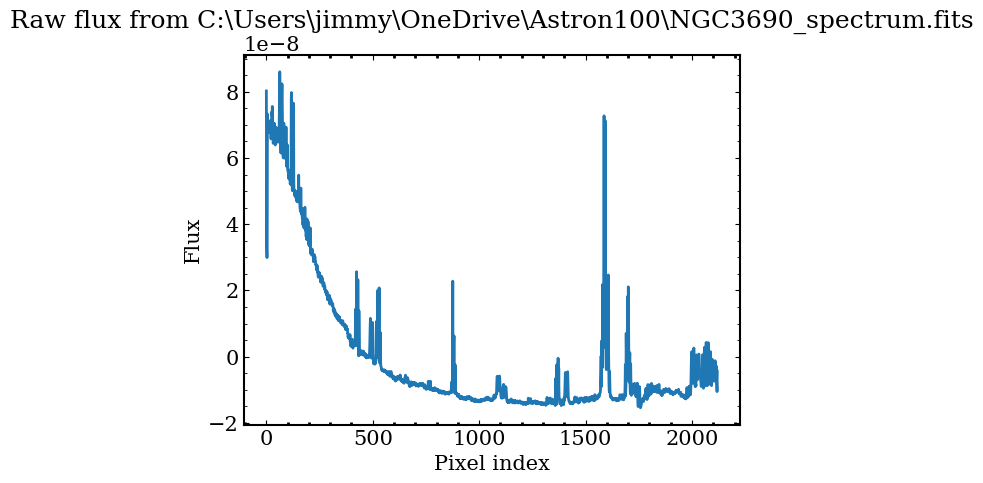

BL Lac


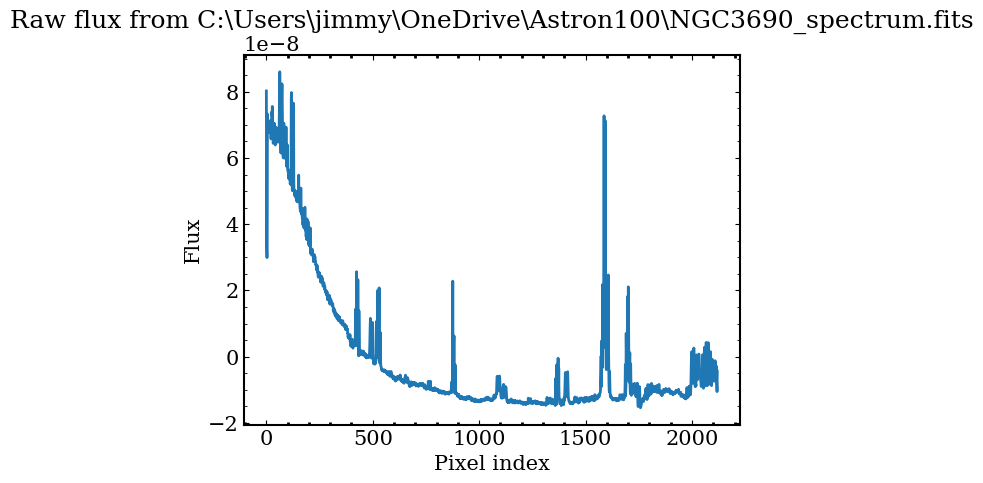

BL Lac


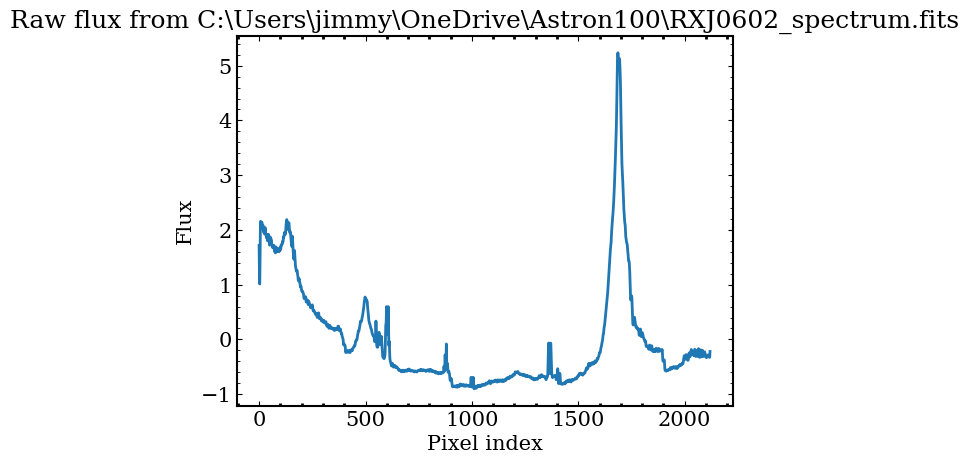

BL Lac


In [10]:
file = r"C:\Users\jimmy\OneDrive\Astron100\qso_bottom5\bottom_qso_004_z3.00.fits"
print(predict_single(file, "fits", model))

file2 = r"C:\Users\jimmy\Downloads\ZBLLAC_PKS_B1256-229_1_spectrum.txt"
print(predict_single(file2, "txt", model))

file3 = r"C:\Users\jimmy\OneDrive\Astron100\sdss_spectra_seyfert\LEDA_36541.fits"
print(predict_single(file3, "fits", model))

file4 = r"C:\Users\jimmy\OneDrive\Astron100\sdss_spectra_dual\J0914+0853ES.fits"
print(predict_single(file4, "fits", model))

file5 = r"C:\Users\jimmy\OneDrive\Astron100\RXJ0602_spectrum.fits"
print(predict_single(file5, "fits", model))

file6 = r"C:\Users\jimmy\OneDrive\Astron100\NGC3690_spectrum.fits"
print(predict_single(file6, "fits", model))

file7 = r"C:\Users\jimmy\OneDrive\Astron100\NGC3690_spectrum.fits"
print(predict_single(file7, "fits", model))

file8 = r"C:\Users\jimmy\OneDrive\Astron100\RXJ0602_spectrum.fits"
print(predict_single(file8, "fits", model))

